<a href="https://colab.research.google.com/github/ka4on/Waste-Classification/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Waste Classification with CNN

This project uses kaggle [waste classification](https://www.kaggle.com/datasets/techsash/waste-classification-data) dataset and try to classify if the waste is organic or recycable.

In [ ]:
!pip install tensorflow_datasets
!pip install --upgrade tensorflow
!pip install opendatasets
!pip install --upgrade skillsnetwork

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Libraries

In [ ]:
import numpy as np
import datetime
import os
import random, shutil
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread
import cv2
from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import pandas as pd

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Activation, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

2.12.0


### EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML/archive.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  inflating: dataset/DATASE

In [ ]:
train_path = "/content/DATASET/TRAIN"
test_path = "/content/DATASET/TEST"

In [ ]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 9999/9999 [00:12<00:00, 790.39it/s] 


In [ ]:
data.shape

(22564, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

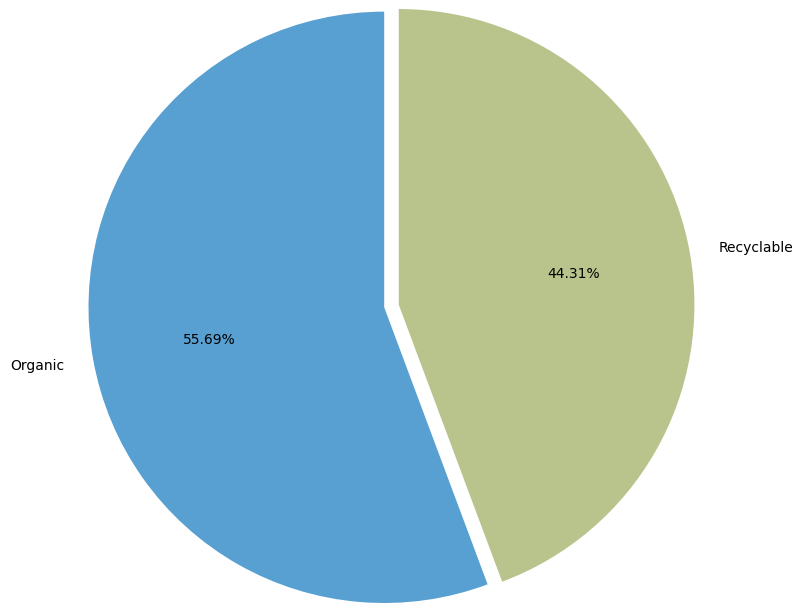

In [ ]:
colors = ['#57a0d1', '#b8c48b']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

for the train set, we have 55% organic and 44% recyclable.

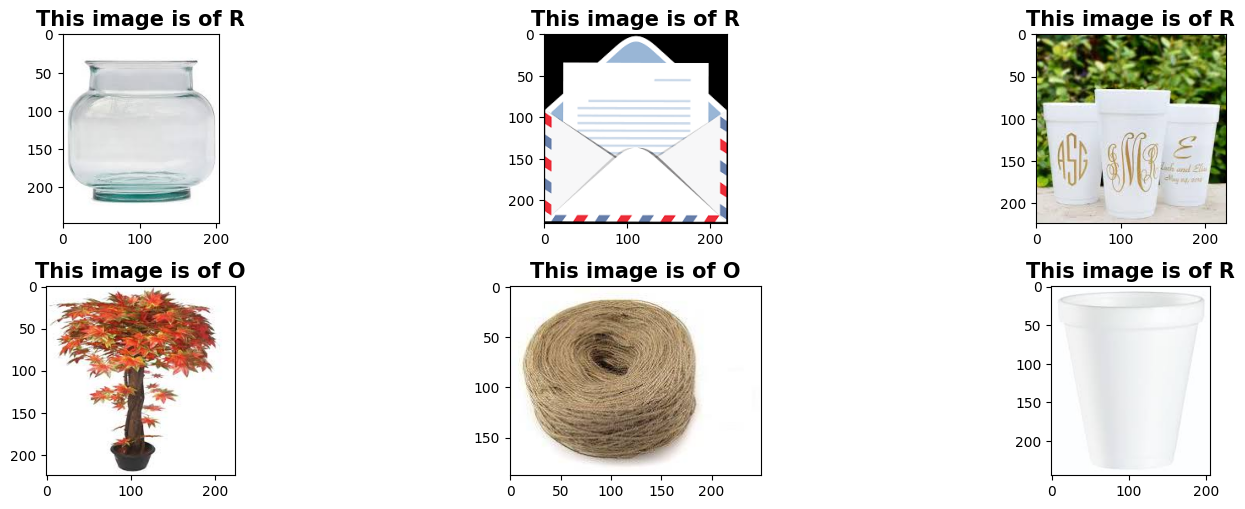

In [ ]:
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':15,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

### Modeling

We use transfer learning to avoid heavy computational cost from training a new model from scratch. We will keep the early layers of a pre-trained network, and re-train the later layers on a specific dataset to capture features that are more specific for our task.

Define Configurations

In [ ]:
img_rows, img_cols = 150, 150
batch_size = 128
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = "/content/DATASET/TRAIN"
path_test = "/content/DATASET/TEST"
input_shape = (img_rows, img_cols, 3) #RGB
labels = ['O', 'R']
seed = 10
checkpoint_path='ORnet.h5'

Load Images using ImageGenerator Class

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	  width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	  width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

It takes the ImageDataGenerator training/validation sets and flows image batches from a specified folder.

In [ ]:
# use the labels defined before to 
# find number of images belonging to each category
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

Found 18052 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

Found 4512 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    class_mode='binary',
    seed = seed,
    batch_size = batch_size, 
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 2513 images belonging to 2 classes.


Look at the augmented picture samples

Labels: ['O', 'O', 'O', 'O', 'O']


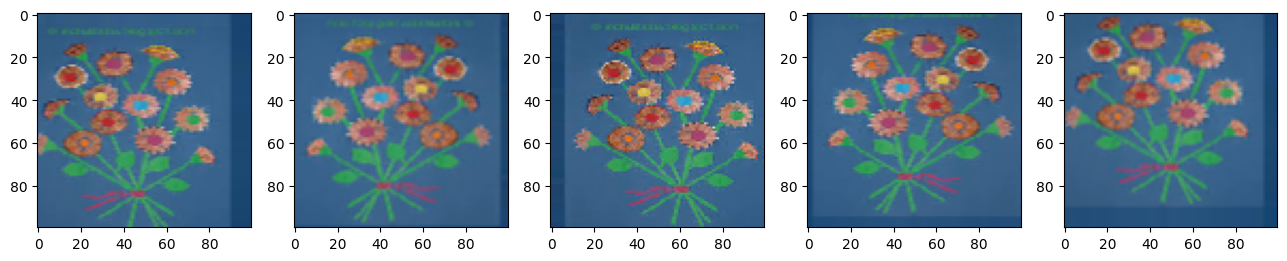

In [ ]:
IMG_DIM = (100, 100)

train_files = glob('/content/DATASET/TRAIN/O/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[4].split('.')[0].strip() for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

### CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32,(3,3),input_shape = (150,150,3)))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D())

model_cnn.add(Conv2D(64,(3,3)))  
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D())

model_cnn.add(Conv2D(128,(3,3)))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D())

model_cnn.add(Flatten())
model_cnn.add(Dense(256))
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(64))
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1)) # output
model_cnn.add(Activation("sigmoid"))

model_cnn.compile(loss = "binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics = ["accuracy"])


In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                    

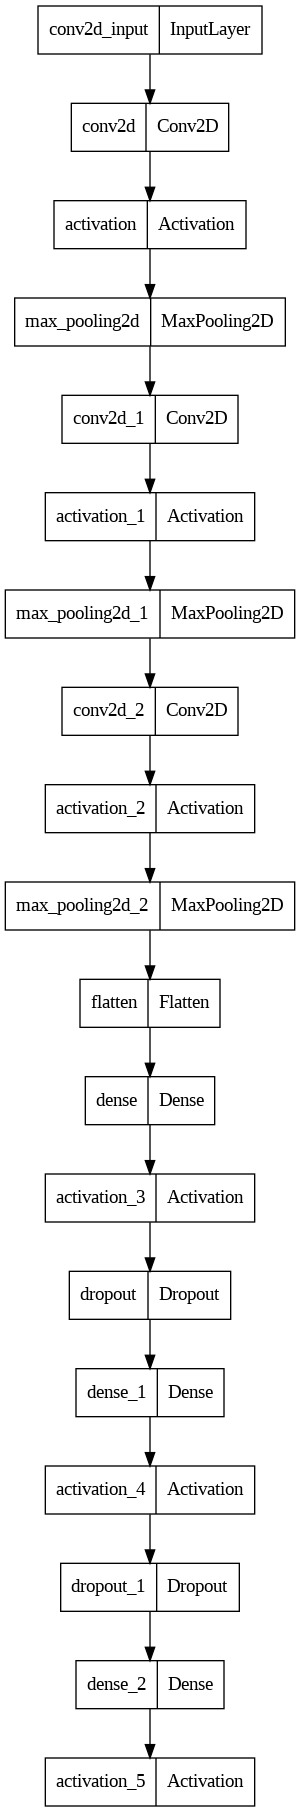

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn)

In [ ]:
checkpoint_path='O_R_tlearn_image_augm_cnn.h5'
keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

hist = model_cnn.fit(
        train_generator, 
        epochs=10,
        validation_data = val_generator,
        callbacks = keras_callbacks
        ) 

Epoch 1/10
142/142 [==============================] - 136s 889ms/step - loss: 0.5715 - accuracy: 0.7221 - val_loss: 0.4743 - val_accuracy: 0.7657
Epoch 2/10
142/142 [==============================] - 126s 885ms/step - loss: 0.4904 - accuracy: 0.7837 - val_loss: 0.4442 - val_accuracy: 0.7870
Epoch 3/10
142/142 [==============================] - 125s 882ms/step - loss: 0.4670 - accuracy: 0.7986 - val_loss: 0.4913 - val_accuracy: 0.7586
Epoch 4/10
142/142 [==============================] - 125s 881ms/step - loss: 0.4543 - accuracy: 0.8058 - val_loss: 0.4344 - val_accuracy: 0.7857
Epoch 5/10
142/142 [==============================] - 126s 885ms/step - loss: 0.4442 - accuracy: 0.8128 - val_loss: 0.4319 - val_accuracy: 0.7846
Epoch 6/10
142/142 [==============================] - 126s 885ms/step - loss: 0.4357 - accuracy: 0.8149 - val_loss: 0.4465 - val_accuracy: 0.7753
Epoch 7/10
142/142 [==============================] - 125s 882ms/step - loss: 0.4307 - accuracy: 0.8180 - val_loss: 0.4272 -

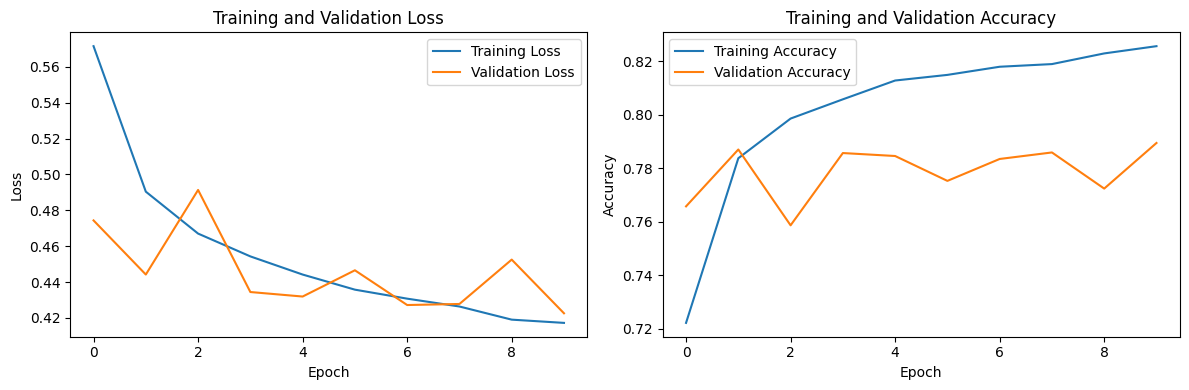

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the loss history
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

### VGG-16

Load the model

In [ ]:
from keras.applications import vgg16
input_shape = (150, 150, 3)

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

58889256/58889256 [==============================] - 1s 0us/step


We flatten the output of a vgg model and assignee it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [ ]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Freeze the base model

In [ ]:
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

Create a new model on top. We add a Dropout layer for regularization

In [ ]:
model=Sequential()
model.add(basemodel)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1024)              8389632   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                      

Compile the model

In [ ]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics = ["accuracy"],
              optimizer=OPT)

use early stopping to avoid over-training

In [ ]:
from keras.callbacks import LearningRateScheduler
checkpoint_path='O_R_tlearn_image_augm_cnn_vgg16.h5'

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [keras_callbacks]

Train the model

In [ ]:
extract_feat_model = model.fit(train_generator, 
                              epochs=10,
                              validation_data=val_generator, 
                              validation_steps=10, 
                              verbose=1,
                              callbacks = callbacks_list_)  

Epoch 1/10
142/142 [==============================] - 114s 767ms/step - loss: 0.3461 - accuracy: 0.8586 - val_loss: 0.3311 - val_accuracy: 0.8609
Epoch 2/10
142/142 [==============================] - 109s 765ms/step - loss: 0.2499 - accuracy: 0.8979 - val_loss: 0.3089 - val_accuracy: 0.8750
Epoch 3/10
142/142 [==============================] - 109s 765ms/step - loss: 0.2144 - accuracy: 0.9127 - val_loss: 0.2889 - val_accuracy: 0.8883
Epoch 4/10
142/142 [==============================] - 108s 759ms/step - loss: 0.1898 - accuracy: 0.9238 - val_loss: 0.3697 - val_accuracy: 0.8555
Epoch 5/10
142/142 [==============================] - 108s 764ms/step - loss: 0.1793 - accuracy: 0.9282 - val_loss: 0.3167 - val_accuracy: 0.8805
Epoch 6/10
142/142 [==============================] - 109s 768ms/step - loss: 0.1601 - accuracy: 0.9370 - val_loss: 0.3402 - val_accuracy: 0.8656
Epoch 7/10
142/142 [==============================] - 109s 769ms/step - loss: 0.1460 - accuracy: 0.9426 - val_loss: 0.3982 -

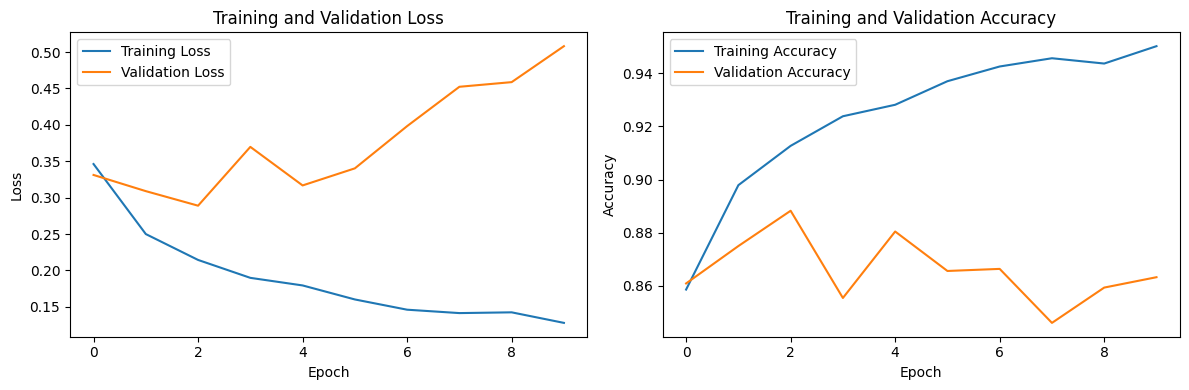

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the loss history
loss = extract_feat_model.history['loss']
val_loss = extract_feat_model.history['val_loss']
accuracy = extract_feat_model.history['accuracy']
val_accuracy = extract_feat_model.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

### Fine Tune

In [ ]:
[layer.name for layer in basemodel.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

We then set 'block5_conv1'and 'block4_conv1'  to trainable

In [ ]:
basemodel.trainable = True

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model=Sequential()
model.add(basemodel)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

checkpoint_path='O_R_tlearn_image_augm_fine_tune_vgg16.h5'

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [keras_callbacks]

OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics = ["accuracy"],
              optimizer=OPT)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dropout_5 (Dropout)         (None, 8192)              0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 1024)              8389632   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [ ]:
fine_tune_model = model.fit(train_generator,  
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=10, 
                    verbose=1)  

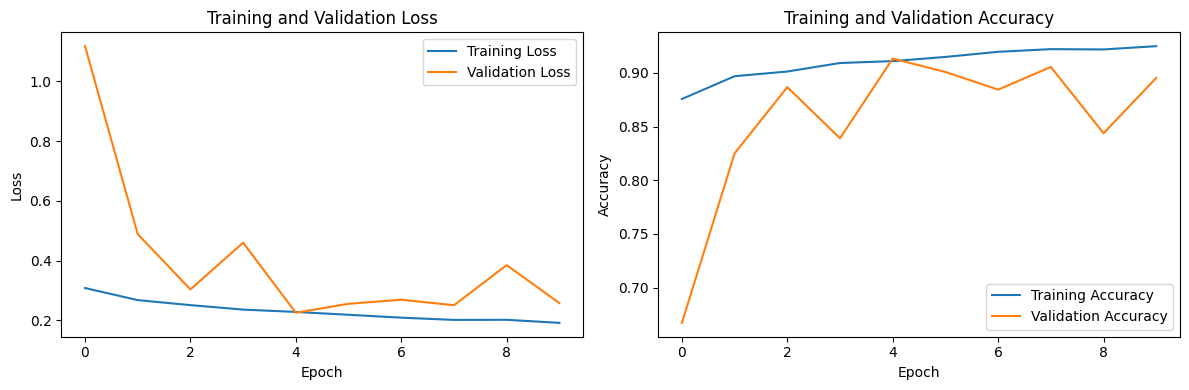

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the loss history
loss = fine_tune_model.history['loss']
val_loss = fine_tune_model.history['val_loss']
accuracy = fine_tune_model.history['accuracy']
val_accuracy = fine_tune_model.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


### Evaluation on test data

In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/ML/O_R_tlearn_image_augm_cnn.h5')
extract_feat_model = tf.keras.models.load_model('/content/drive/MyDrive/ML/O_R_tlearn_image_augm_cnn_vgg16.h5')
fine_tune_model = tf.keras.models.load_model('/content/drive/MyDrive/ML/O_R_tlearn_image_augm_fine_tune_vgg16.h5')

Load test images:

In [ ]:
from sklearn.utils import shuffle


IMG_DIM = (150, 150)

# Read in all O and R test images file paths. Shuffle and select 50 random test images. 
test_files_O = glob("/content/DATASET/TEST/O/*")
test_files_R = glob("/content/DATASET/TEST/R/*")
test_files = test_files_O + test_files_R


# Extract label from file path
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[4].split('.')[0].strip() for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [ ]:
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

In [ ]:
predictions_cnn_model = cnn_model.predict(test_imgs_scaled, verbose=0)
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

In [ ]:
predictions_cnn_model = num2class_lt(predictions_cnn_model)
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

In [ ]:
print('CNN Model')
print(metrics.classification_report(test_labels, predictions_cnn_model))
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

CNN Model
              precision    recall  f1-score   support

           O       0.81      0.95      0.88      1401
           R       0.92      0.72      0.81      1112

    accuracy                           0.85      2513
   macro avg       0.87      0.84      0.85      2513
weighted avg       0.86      0.85      0.85      2513

Extract Features Model
              precision    recall  f1-score   support

           O       0.83      0.96      0.89      1401
           R       0.94      0.75      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.89      0.86      0.86      2513
weighted avg       0.88      0.87      0.87      2513

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.91      0.93      0.92      1401
           R       0.91      0.89      0.90      1112

    accuracy                           0.91      2513
   macro avg       0.91      0.91      0.91      2513
weighted avg       0.91 

In [ ]:
!cp /content/O_R_tlearn_image_augm_fine_tune_vgg16.h5 /content/drive/MyDrive/ML

In [ ]:
!cp /content/O_R_tlearn_image_augm_cnn_vgg16.h5 /content/drive/MyDrive/ML

In [ ]:
!cp /content/O_R_tlearn_image_augm_cnn.h5 /content/drive/MyDrive/ML